<a href="https://colab.research.google.com/github/aviplane/paircreation-analysis/blob/main/MomentumSpaceAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
### Google Drive
from google.colab import drive
drive.mount('/gdrive', force_remount= True)
drive_location = '/gdrive/Shared drives/Cavity Drive/CavityLab Analysis/2020_PairCreation/'
import os

Mounted at /gdrive


In [2]:
!pip install colorcet

     |████████████████████████████████| 1.6MB 9.9MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from colorcet import cm
from datetime import date
correlation_colormap = cm.gwv
import matplotlib.animation as animation

from matplotlib import rcParams
import matplotlib as mpl
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['axes.grid'] = True
###Some notes
### alpha > 0 preferred to dashed lines
magnetization_colormap = cm.coolwarm
phase_colormap = "hsv"
contrast_colormap = cm.fire
correlation_colormap = cm.coolwarm
labelsize = 13

def transparent_edge_plot(ax, x, y, yerr = None , marker = 'o', ms = 12, **kwargs):
    if yerr is not None:
        base,_,_ = ax.errorbar(x, y, yerr, ms = ms, marker = marker, linestyle ="None", alpha =0.6, markeredgewidth = 2, **kwargs)
    else:
        base, = ax.plot(x, y, ms = ms, marker = marker, linestyle ="None", alpha =0.5, markeredgewidth = 2, **kwargs)
    ax.plot(x, y, ms =ms, marker =marker, linestyle ="None", markeredgecolor = base.get_color(), markerfacecolor ="None", markeredgewidth =2)
    return ax, base

def plot_2d(correlations, values):
    dv = np.diff(values)[0]
    positions = correlations.shape[1]//2
    extent = [-positions, positions, np.min(values) + dv/2, 
            np.max(values) - dv/2]

    fig, ax = plt.subplots()
    cax = ax.imshow(correlations, 
            aspect = "auto", 
            cmap = correlation_colormap, 
            vmin = -1, 
            vmax = 1, extent = extent)
    fig.colorbar(cax, ax = ax)
    ax.grid(False)
    return fig, ax

def make_animation(correlations, values, units = "us"):
    fig, ax = plt.subplots()
    im = ax.imshow(correlations[0], 
                animated=True, 
                cmap = correlation_colormap,
                vmin = -1,
                vmax = 1
                )
    fig.colorbar(im, ax = ax)
    ax.grid(False)
    ax.set_xlabel(r"$|1, -1\rangle$ position", fontsize = labelsize)
    ax.set_ylabel(r"$|1, 1\rangle$ position", fontsize = labelsize)
    def updatefig(i):
        ax.set_title(f"{values[i]} {units}")
        im.set_array(correlations[i])
        return im,

    ani = animation.FuncAnimation(fig, updatefig, frames = len(correlations),  blit=True)
    return ani

def corr_plot(corr):
    fig, ax = plt.subplots()
    cax = ax.imshow(corr, vmin = -1, vmax = 1, cmap = cm.coolwarm)
    fig.colorbar(cax, ax = ax)
    ax.set_xlabel("1, 1 Position", fontsize = labelsize)
    ax.set_ylabel("1, -1 Position", fontsize = labelsize)
    return fig, ax
import re


# Data

Here are the uploaded folders, can hopefully just type in a folder name, and the functions below generate the plots.  Right now output is in the main folder to be analyzed, e.g. Cavity Drive/CavityLab Analysis/2020_PairCreation/2020-12-18-alternating

In [4]:
### data_folders
## Spreading @ 4 sites - 2020-12-25-Spreading
## Sign changing vs. phase @ distance 4 - 2020-12-25-Phase
## (-) correlations at distance = 1, (+) correlations at distance = 2 - 2020-12-18-alternating
## (-) correlations at distance = 2, (+) correlations at distance = 3, 4 - 2020-12-18-3distances
## Spreading at distance = 3 - 2020-12-17-3sites.  This one might look best, but it's a bit cheating, since the raman pulses go every 3, so it's a little less agnostic to the pi/2 pulse


data_folder = "2020-12-25-Spreading"
folder_to_save = drive_location + "SpreadingSign/" + data_folder
folders = glob.glob(folder_to_save + "/*/")

### Extract variable + Units from folder name
name = folders[0].split("/")[-2]
label = folders[0].split("_")[-2]
label_split = re.split('(\d+)', label)
label_str = label_split[0]
unit = label_split[-1]
unit = "_" if unit == '' else unit
print(f"label: {label_str}, unit: {unit}")

def get_duration(folder):
    time = float(folder.split(label_str)[-1].split(unit)[0])
    return time

### Sort folders
folders = sorted(folders, key = get_duration)

### Set label for the summary plot
label = f"{label_str} ({unit})"


label: IntDuration, unit: us


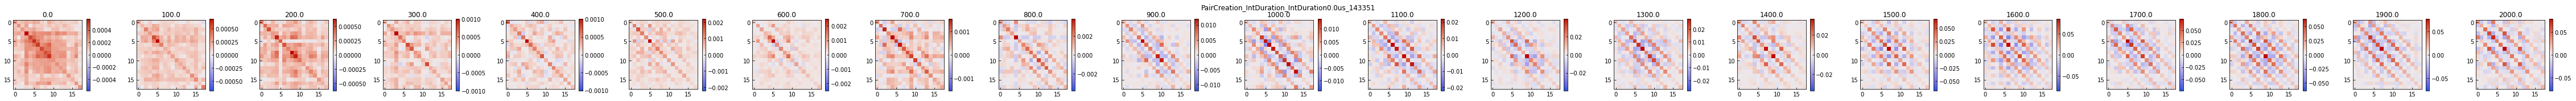

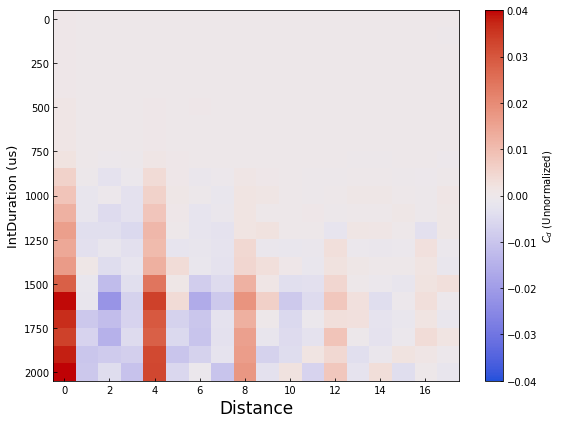

In [5]:
def get_values(folder, f2_threshold = 1.5):
    fits = np.load(f"{folder}/all_fits.npy")
    roi_labels = list(np.load(f"{folder}/roi_labels.npy"))
    f2 = fits[:, roi_labels.index("roi2orOther")]
    f2 = np.mean(f2, axis=1)
    f2_mean = np.mean(f2)
    f2_std = np.std(f2)
    mask = f2 > (f2_mean - f2_threshold * f2_std)

    masked_fits = fits[mask]
    m = masked_fits[:, roi_labels.index("roi1-1")]
    p = masked_fits[:, roi_labels.index("roi11")]
    z = masked_fits[:, roi_labels.index("roi10")]
    return m, p, z

def make_plot(folder, fig, ax, normalize = True, key = get_duration, f2_threshold = 1.5):
    m, p, z = get_values(folder, f2_threshold = f2_threshold)
    t = m + p + z
    Fz = ((p/t)[:, :] - (m/t)[:, :])
    n_shots, n_traps = Fz.shape
    corr = np.corrcoef(Fz, rowvar = False) if normalize else np.cov(Fz, rowvar = False)
    mx = np.max(np.abs(corr))
    cax = ax.imshow(corr, cmap = correlation_colormap, vmin = -mx, vmax = mx)
    fig.colorbar(cax, ax = ax)
    ax.grid(False)
    title = key(folder)
    ax.set_title(f"{title}")
    ax.grid(False)    
    return corr

def diag_corr(corr):
    positions = list(range(corr.shape[-1]))
    total_diag = [np.mean(np.diagonal(corr, d)) for d in positions]
    return total_diag

def plot_time(cov_mw, durations, normalized_label):
    fig, ax = plt.subplots(figsize = (8, 6))
    d_dur = np.diff(durations)[0]
    diags = np.array([diag_corr(i) for i in cov_mw])
    mag = np.max(np.abs(diags))
    extent = [-0.5, diags.shape[1]-0.5, np.max(durations) + d_dur/2, np.min(durations) - d_dur/2]
    cax = ax.imshow(diags, vmin = -mag, vmax = mag, cmap = correlation_colormap,
              extent = extent, aspect = "auto")
    fig.colorbar(cax, ax = ax, label = "$C_d$ " + normalized_label)
    ax.grid(False)
    ax.set_xlabel(r"Distance", fontsize = labelsize + 4)
    ax.set_ylabel(label, fontsize = labelsize)
    fig.tight_layout()
    #fig.savefig(f"{folder_to_save}/summary_1d_{name}.pdf", dpi = 200)

def summary_plot(folders, key = get_duration, normalize = False, f2_threshold = 1.5):
    name = folders[0].split("/")[-2]
    data_location = folders[0].split("/")[-2]
    fig, ax = plt.subplots(1, len(folders), figsize = (3 * len(folders), 2.4))
    if len(folders) > 1:
        mean_cov = np.array([make_plot(folders[i], 
                                       fig, ax[i], 
                                       normalize = normalize, 
                                       key = key
                                       ) for i in range(len(folders))])
    else:
        make_plot(folders[0], fig, ax, normalize = False)
    fig.tight_layout(rect = (0, 0, 1, 0.93))
    fig.suptitle(f"{data_location}")
    #fig.savefig(f"{folder_to_save}/all_summary_{name}.pdf")
    normalized_label = "(Normalized)" if normalize else "(Unnormalized)"
    durations = np.array([key(i) for i in folders])
    plot_time(mean_cov, durations, normalized_label)   
    return mean_cov

normalize = False
cov = summary_plot(folders, normalize = normalize)

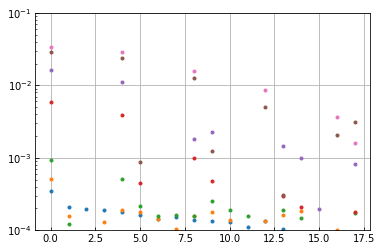

In [6]:
for data in cov[::3]:
  plt.plot(diag_corr(data),'.')
  plt.yscale("log")
  plt.ylim(10**-4,10**-1)

## Momentum Space

Here we decompose each shot into momentum modes and then average the magnitude of the componenets over multiple shots. $F^x_l \propto a_l + a_l^\dagger + b_l + b_l^\dagger$, where $a_l$ and $b_l$ are in the rotating frame. We can compute $$F_k + F_{-k} \equiv \sum_l(e^{i 2\pi k l/M} + e^{-i 2\pi k l/M}) F^x_l \propto a_k + a_k^\dagger + b_k + b_k^\dagger + a_{-k} + a_{-k}^\dagger + b_{-k} + b_{-k}^\dagger$$

In [13]:
def get_values(folder, f2_threshold = 1.5):
    fits = np.load(f"{folder}/all_fits.npy")
    roi_labels = list(np.load(f"{folder}/roi_labels.npy"))
    f2 = fits[:, roi_labels.index("roi2orOther")]
    f2 = np.mean(f2, axis=1)
    f2_mean = np.mean(f2)
    f2_std = np.std(f2)
    mask = f2 > (f2_mean - f2_threshold * f2_std)

    masked_fits = fits[mask]
    m = masked_fits[:, roi_labels.index("roi1-1")]
    p = masked_fits[:, roi_labels.index("roi11")]
    z = masked_fits[:, roi_labels.index("roi10")]
    return m, p, z

def momentum_space(folder, f2_threshold = 1.5):
    m, p, z = get_values(folder, f2_threshold = 1.5)
    t = m + p + z
    F_x = (p-m)/t
    M = F_x.shape[1]
    F_k = [F_x@np.cos(2*np.pi*k*np.arange(M)/(M)) for k in range(M)]
    return F_k


Look at all mode simultaneously:

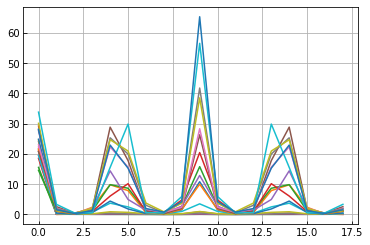

In [20]:
for folder in folders:
  plt.plot(np.arange(18),np.sum(np.abs(momentum_space(folder))**2,1))

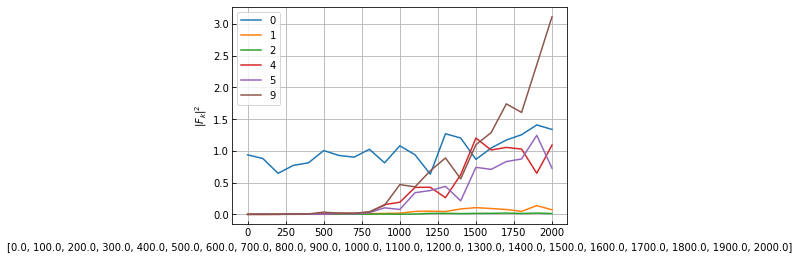

In [23]:
data = np.zeros((18,len(folders)))
for i in range(len(folders)):
  data[:,i] = np.mean(np.abs(momentum_space(folders[i]))**2,1)
times = [get_duration(folder) for folder in folders]
modes_of_interest = np.array([0,1, 2,4,5,9])
for mode in modes_of_interest:
  plt.plot(times,data[mode,:])
plt.xlabel(times)
plt.ylabel(r"$|F_k|^2$")
plt.legend(modes_of_interest)

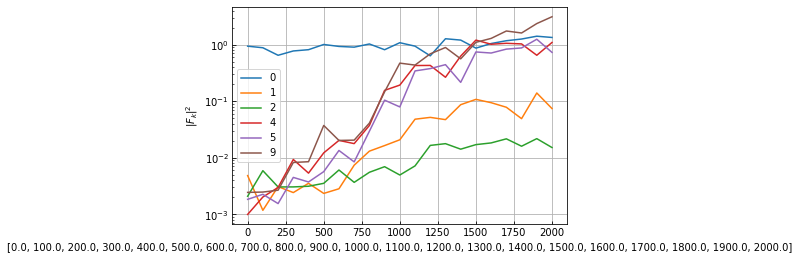

In [25]:
data = np.zeros((18,len(folders)))
for i in range(len(folders)):
  data[:,i] = np.mean(np.abs(momentum_space(folders[i]))**2,1)
times = [get_duration(folder) for folder in folders]
modes_of_interest = [0,1,2,4,5,9]
for mode in modes_of_interest:
  plt.plot(times,data[mode,:])
plt.xlabel(times)
plt.ylabel(r"$|F_k|^2$")
plt.yscale("log")
plt.legend(modes_of_interest)

Redo using sine instead of cos

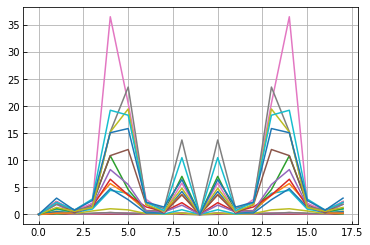

In [26]:
def momentum_space(folder, f2_threshold = 1.5):
    m, p, z = get_values(folder, f2_threshold = 1.5)
    t = m + p + z
    F_x = (p-m)/t
    M = F_x.shape[1]
    F_k = [F_x@np.sin(2*np.pi*k*np.arange(M)/M) for k in range(M)]
    return F_k
    
for folder in folders:
  plt.plot(range(18),np.sum(np.abs(momentum_space(folder))**2,1))

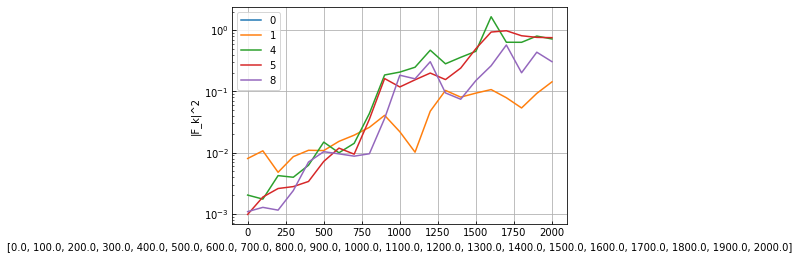

In [27]:
data = np.zeros((18,len(folders)))
for i in range(len(folders)):
  data[:,i] = np.mean(np.abs(momentum_space(folders[i]))**2,1)
times = [get_duration(folder) for folder in folders]
modes_of_interest = [0,1,4,5,8]
for mode in modes_of_interest:
  plt.plot(times,data[mode,:])
plt.xlabel(times)
plt.ylabel(r'|F_k|^2')
plt.yscale("log")
plt.legend(modes_of_interest)